# EXPLORATORY ANALYSIS OF VICTORY IN THE 21ST CENTURY

## Contents

<ul>
    <li><a href='#imp-mod'>Import modules</a></li>
    <li><a href='#conn-db'>Connect to database</a></li>
    <li><a href='#preprocess'>Preprocessing</a></li>
    <li><a href='#analysis'>Match analysis</a></li>
    <ul>
        <li><a href='#period'>Which periods of the year are most busy?</a></li>
        <li><a href='#month'>Which months do players perform best?</a></li>
        <li><a href='#corr'>What is the correlation between number of matches played and ability to win?</a></li>
        <li><a href='#year'>How prosperous has South Africa been over the years in the 21st century?</a></li>
        <li><a href='#toss'>Should South Africa toss, field or bat first?</a></li>
    </ul>
    <li><a href='#close-db'>Close database connection</a></li>
</ul>

<br><hr><br>

## Import modules<a id='imp-mod'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

%matplotlib inline

<br><hr><br>

## Connect to database<a id='conn-db'></a>

In [2]:
conn = sqlite3.connect('./../sa_cricket.db')
cursor = conn.cursor()

<br><hr><br>

## Preprocessing<a id='preprocess'></a>

In [3]:
query = '''select
            strftime("%Y", m.match_date) as Year, 
            strftime("%m", m.match_date) as Month,
            m.match_date as Date,
            o.opp_name as Opposition,
            g.ground_name as Ground,
            g.country as Host,
            m.result as Result,
            m.toss as Toss
            from mat as m join
            opposition as o join
            ground as g
            where m.opposition=o.opp_id and m.ground=g.ground_id;
        '''
df = pd.read_sql_query(query, conn)
df.head()

,Year,Month,Date,Opposition,Ground,Host,Result,Toss
0,2000,03,2000-03-09,India,Nehru Stadium,India,India led the 5-match series 1-0,"South Africa , elected to bat first"
1,2000,03,2000-03-12,India,Keenan Stadium,India,India led the 5-match series 2-0,"South Africa , elected to bat first"
2,2000,03,2000-03-15,India,Nahar Singh Stadium,India,India led the 5-match series 2-1,"South Africa , elected to field first"
3,2000,03,2000-03-17,India,Reliance Stadium,India,India led the 5-match series 3-1,"South Africa , elected to bat first"
4,2000,03,2000-03-19,India,Vidarbha Cricket Association Ground,India,India won the 5-match series 3-2,"India , elected to field first"


In [4]:
def winner(result):
    '''
    Input game result e.g 'India led the 5-match series 1-0'
    Return Winner e.g 'India'
    '''
    if result == '':
        # This are non-tour games such as world cup and series
        winner = 'No result'
    else:
        if 'led' in result:
            winner = result.split(' led ')[0]
        elif 'won' in result:
            winner = result.split(' won ')[0]
        elif 'advanced' in result:
            winner = result.split(' advanced')[0]
        # There would be a need to handle cases like:
        # 3-match series level 1-1
        # 3-match series drawn 1-1
        elif 'level' in result:
            winner = 'Unknown-level'
        elif 'drawn' in result:
            winner = 'Unknown-draw'
        else:
            winner = 'Unknown'
    return winner
    '''
    The options from above are:
        [Country]
        No result
        Unknown*
    I believe it would better to somehow find winners among Unknown*s
    '''    

God! I repeated this so much. Almost done before noticed

`win_by_\*.rename(columns={0: 'Unknown', -1: 'Lost', 1: 'Won'}, inplace=True)`

Next time, decide before you return. Just kidding, even right now I'm still confused on whether to return int or str for toss. 

In [5]:
def point(result):
    '''
    To make things simpler so that outcome of winner is either:
        1 for Win
        0 for Unknown or No result
        -1 for Losses
    '''
    w = winner(result)
    if ('Unknown' in w) or w=='No result':
        return 0
    elif w=='South Africa':
        return 1
    else:
        return -1

In [6]:
'''
Get tosser and their choice from toss e.g 'South Africa , elected to bat first'
'''
def tosser(t):
    t_split = t.split(' , elected to ')
    tosser = t_split[0]
    return tosser

def toss(t):
    # Return 1 if South Africa tossed
    toss = tosser(t)
    if toss=='South Africa':
        return 1
    else:
        return 0

def choice(t):
    t_split = t.split(' , elected to ')
    choice = t_split[1]
    return choice

In [7]:
df['Point'] = df['Result'].apply(point)
df['Tossed'] = df['Toss'].apply(toss)
df['Toss Choice'] = df['Toss'].apply(choice)

# Drop Result and Toss after getting what's needed
df.drop(['Result', 'Toss'], axis=1, inplace=True)
df.head()

,Year,Month,Date,Opposition,Ground,Host,Point,Tossed,Toss Choice
0,2000,03,2000-03-09,India,Nehru Stadium,India,-1,1,bat first
1,2000,03,2000-03-12,India,Keenan Stadium,India,-1,1,bat first
2,2000,03,2000-03-15,India,Nahar Singh Stadium,India,-1,1,field first
3,2000,03,2000-03-17,India,Reliance Stadium,India,-1,1,bat first
4,2000,03,2000-03-19,India,Vidarbha Cricket Association Ground,India,-1,0,field first


<br><hr><br>

## Match analysis<a id='analysis'></a>

### Which periods of the year are most busy?<a id='period'></a>

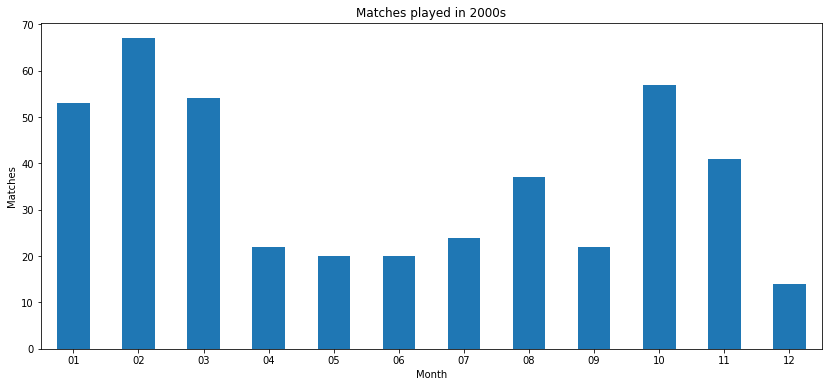

In [8]:
# Number of matches played each month since 2000
match_by_month = df.groupby(by='Month').count()['Point']   #/20 to get the average
match_by_month.plot(kind='bar', figsize=(14,6))
plt.title('Matches played in 2000s')
plt.ylabel('Matches')
plt.xlabel('Month')
plt.xticks(rotation=0)
plt.show()

#### The first three months are most busy and followed immediately with the least busy months.
The last month is understandable (christmas and holiday period)

<hr>

### Which months do players perform best?<a id='month'></a>

In [9]:
# Number of matches played each month since 2000

'''
# This commented section does the same thing as win_by_month.
# Kept for reference purpose
match_by_month = df[['Month', 'Point']].groupby(by=['Month','Point'], as_index=False)
match_by_month.size().unstack(fill_value=0)
'''

win_by_month = df.pivot_table(index='Month', columns='Point', aggfunc='size', fill_value=0)
win_by_month.rename(columns={0: 'Unknown', -1: 'Lost', 1: 'Won'}, inplace=True)


In [10]:
# Total games that leads to either a win or loss
win_by_month['Total Games'] = win_by_month['Lost'] + win_by_month['Won']

# Percent of Total games won
win_by_month['Percent Won'] = (win_by_month['Won'] * 100) / win_by_month['Total Games']

# Absolute total of games played including '-' result
win_by_month['Absolute Total'] = win_by_month['Total Games'] + win_by_month['Unknown']

# Drop column name
win_by_month.columns.name=''

win_by_month

,Lost,Unknown,Won,Total Games,Percent Won,Absolute Total
Month,,,,,,
01,6,19,28,34,82.352941,53
02,16,23,28,44,63.636364,67
03,13,21,20,33,60.606061,54
04,6,11,5,11,45.454545,22
05,3,2,15,18,83.333333,20
06,0,17,3,3,100.000000,20
07,9,11,4,13,30.769231,24
08,12,11,14,26,53.846154,37
09,2,10,10,12,83.333333,22


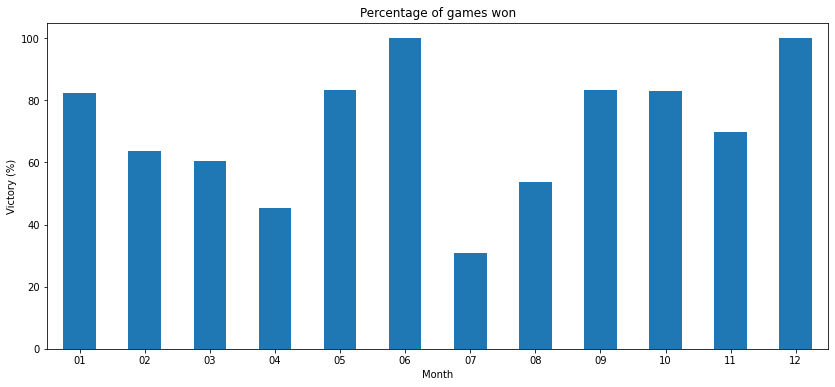

In [11]:
win_by_month['Percent Won'].plot(kind='bar', figsize=(14,6))
plt.xticks(rotation=0)
plt.ylabel('Victory (%)')
plt.title('Percentage of games won')
plt.show()

#### The Best Months are June and December. The most with least games.

Also note that the best month is followed immediately by worst month, August.
Why? There's just a little increase in the number of games played

<hr>

### What is the correlation between number of matches played and ability to win?<a id='corr'></a>

In [12]:
win_by_month.corr()['Percent Won']


Lost             -0.659865
Unknown          -0.173735
Won               0.190523
Total Games      -0.109293
Percent Won       1.000000
Absolute Total   -0.148523
Name: Percent Won, dtype: float64

#### There's no strong correlation between Percent and anything else except Losses

<hr>

### How prosperous has South Africa been over the years in the 21st century?<a id='year'></a>

In [13]:
win_by_year = df.pivot_table(index='Year', columns='Point', aggfunc='size', fill_value=0)
win_by_year.rename(columns={0: 'Unknown', -1: 'Lost', 1: 'Won'}, inplace=True)

In [14]:
# Total games that leads to either a win or loss
win_by_year['Total Games'] = win_by_year['Lost'] + win_by_year['Won']

# Percent of Total games won
win_by_year['Percent Won'] = (win_by_year['Won'] * 100) / win_by_year['Total Games']

# Absolute total of games played including '-' result
win_by_year['Absolute Total'] = win_by_year['Total Games'] + win_by_year['Unknown']

# Drop column name
win_by_year.columns.name=''

win_by_year

,Lost,Unknown,Won,Total Games,Percent Won,Absolute Total
Year,,,,,,
2000,10,18,12,22,54.545455,40
2001,1,7,13,14,92.857143,21
2002,9,15,14,23,60.869565,38
2003,4,17,1,5,20.000000,22
2004,9,3,5,14,35.714286,17
2005,2,3,17,19,89.473684,22
2006,1,12,11,12,91.666667,24
2007,3,14,12,15,80.000000,29
2008,4,0,12,16,75.000000,16


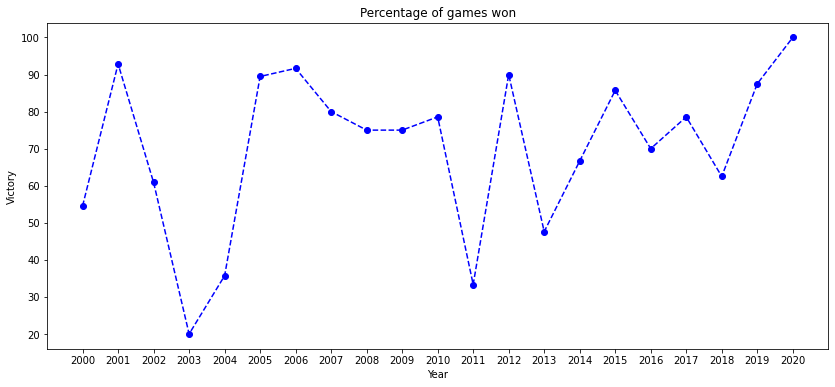

In [15]:
plt.figure(figsize=(14,6))
plt.plot(win_by_year.index, win_by_year['Percent Won'], '--bo')
plt.xticks(rotation=0)
plt.ylabel('Victory')
plt.xlabel('Year')
plt.title('Percentage of games won')
plt.show()

Holy shit!
What the heck happened in 2001-2004 and 2011?

2020 is still fresh but they are starting strong. 2020 has the least total games, 4.

2003 and 2011 have the least total games after 2020. Maybe some results have been misplaced as unknown. 
The drastic change might partly be caused by me.


<hr>

### Should South Africa field or bat first?<a id='toss'></a>

#### Should they even pray to have the toss?

In [16]:
win_by_tosser = df.pivot_table(index='Tossed', columns='Point', aggfunc='size', fill_value=0)
win_by_tosser.rename(columns={0: 'Unknown', -1: 'Lost', 1: 'Won'}, index={0: 'Opposition', 1: 'South Africa'}, inplace=True)

# Percent of games won
win_by_tosser['Percent'] = (win_by_tosser['Won'] * 100) / (win_by_tosser['Won'] + win_by_tosser['Lost'])

# Drop column name
win_by_tosser.columns.name=''
win_by_tosser.head()

,Lost,Unknown,Won,Percent
Tossed,,,,
Opposition,37,75,91,71.093750
South Africa,47,75,106,69.281046


#### There ain't much difference if South Africa has the toss and from the analysis below, fielding or batting first does not drastically change their chance of winning

In [17]:
# Choice is a little more complicated. The choice is for the tosser (not 'South Africa')
win_by_toss = df.pivot_table(index=['Tossed', 'Toss Choice'], columns='Point', aggfunc='size', fill_value=0)
win_by_toss.rename(columns={0: 'Unknown', -1: 'Lost', 1: 'Won'}, index={0: 'Opposition', 1: 'South Africa'}, inplace=True)

# Percent of games won
win_by_toss['Percent'] = (win_by_toss['Won'] * 100) / (win_by_toss['Won'] + win_by_toss['Lost'])

win_by_toss.head()

Point                     Lost  Unknown  Won    Percent
Tossed       Toss Choice                               
Opposition   bat first      22       50   51  69.863014
             field first    15       25   40  72.727273
South Africa bat first      26       45   55  67.901235
             field first    21       30   51  70.833333

<hr>

## Close database connection<a id='close-db'></a>

In [18]:
cursor.close()
conn.close()

<hr>